<a href="https://colab.research.google.com/github/VeerendarGoud/ML-Projects/blob/master/Fresher_datascientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
# importing ML libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,roc_auc_score,auc,accuracy_score

In [0]:
# for data preprocessing.
import json

## Data gathering 


Intial data obervations:
* 



In [0]:
# downloaded the json file form give link https://drive.google.com/file/d/1NEoLthft8j7-BLVs7NH4pApFIcb7-g0z/view
# used from local drive.

## Data preprocessing

In [0]:
# creating different dict for 'paymentMethods', 'transactions', 'orders'

cust_id = 0
custo_dict = []
paym_dict = []
trans_dict= []
frad_dict = []
orders_dict = []

with open('/content/customersdata.json') as fp:
  #line = fp.readline()
  for line in fp:
     y = json.loads(line,parse_float=True, strict=False)

     # add fraudulent type to customer dict
     y['customer']['fraudulent'] = y['fraudulent']

     # adding user id to customer dict
     y['customer']['id'] = cust_id
     custo_dict.append(y['customer'])

     # adding fraudulent type and customer id to paymentMethods dict 
     for dicts in y['paymentMethods']:
       dicts['fraudulent'] = y['fraudulent']
       dicts['id'] = cust_id
    # adding fraudulent type and customer id to transactions dict
     for dicts in y['transactions']:
       dicts['fraudulent'] = y['fraudulent']
       dicts['id'] = cust_id
    # adding fraudulent type and customer id to orders dict 
     for dicts in y['orders']:
       dicts['fraudulent'] = y['fraudulent']
       dicts['id'] = cust_id
     
     # merging all paymentsmethods from all customers into one dict
     paym_dict= paym_dict + y['paymentMethods']
     # merging all transactions from all customers into one dict
     trans_dict = trans_dict + y['transactions']
     # merging all orders from all customers into one dict
     orders_dict = orders_dict + y['orders']

     cust_id += 1
  

In [0]:
# Creating dataframes from the data

orders_df = pd.DataFrame(orders_dict,columns=['id','orderId','orderAmount','orderState','orderShippingAddress','fraudulent'])
trans_df = pd.DataFrame(trans_dict,columns=['id','orderId','transactionId','paymentMethodId','transactionAmount','transactionFailed','fraudulent'])
paym_df = pd.DataFrame(paym_dict,columns = ['id','paymentMethodId','paymentMethodRegistrationFailure','paymentMethodType','paymentMethodProvider','paymentMethodIssuer','fraudulent'])
customer_df = pd.DataFrame(custo_dict,columns=['id','customerEmail', 'customerPhone', 'customerDevice', 'customerIPAddress','customerBillingAddress', 'fraudulent'])

### Start with customer data.

In [7]:
customer_df.head()

,id,customerEmail,customerPhone,customerDevice,customerIPAddress,customerBillingAddress,fraudulent
0,0,josephhoward@yahoo.com,400-108-5415,yyeiaxpltf82440jnb3v,8.129.104.40,"5493 Jones Islands\nBrownside, CA 51896",False
1,1,evansjeffery@yahoo.com,1-788-091-7546,r0jpm7xaeqqa3kr6mzum,219.173.211.202,356 Elizabeth Inlet Suite 120\nPort Joshuabury...,True
2,2,andersonwilliam@yahoo.com,024.420.0375,4m7h5ipl1shyavt6vv2r,67b7:3db8:67e0:3bea:b9d0:90c1:2b60:b9f0,"8478 Sean Ridges Apt. 441\nDavisberg, PR 72250",False
3,3,rubenjuarez@yahoo.com,670.664.8168x94985,slovx60t0i558may4ks0,95de:8565:5a66:792c:26e0:6cfb:7d87:11af,"7769 Elizabeth Bridge Apt. 343\nNortonstad, FM...",False
4,4,uchen@malone.com,1-981-877-0870,j0pd24k5h8dl2fqu0cz4,196.89.235.192,"148 Russell Lodge Apt. 445\nPort Jenniferside,...",True


False    107
True      61
Name: fraudulent, dtype: int64


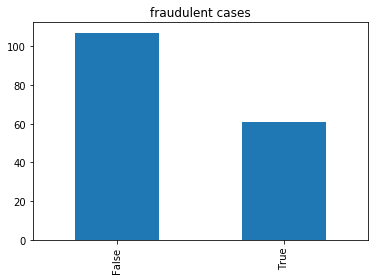

In [8]:
# number of fraudulent and non fraudulent instances

customer_df['fraudulent'].value_counts().plot(kind='bar',title='fraudulent cases');

print(customer_df['fraudulent'].value_counts())

In [0]:
# using ip address to catagorize the device to phone or computer 

customer_df['customerDeviceType'] = customer_df['customerIPAddress'].apply(lambda a: 'computer' if len(a)>16 else 'phone' )

In [10]:
# percentage of type of device used.
customer_df['customerDeviceType'].value_counts()/len(customer_df) *100


phone       54.166667
computer    45.833333
Name: customerDeviceType, dtype: float64

In [11]:
# grouping fradululent and customerDeviceType to find any relation between them.

device_frad = customer_df.groupby(['fraudulent','customerDeviceType'])['id'].count().unstack()
print('percentage in device vs fraud or non fraud')
device_frad/168 *100

percentage in device vs fraud or non fraud


customerDeviceType,computer,phone
fraudulent,,
False,30.952381,32.738095
True,14.880952,21.428571


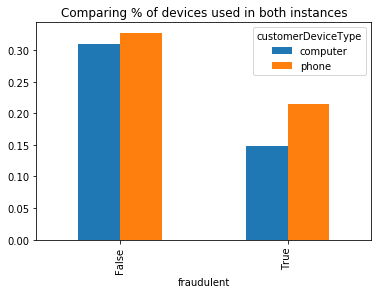

In [12]:
# comparing the devices used in both instances
(device_frad/168).plot(kind='bar',title='Comparing % of devices used in both instances');


In [13]:
# working with address
customer_df['customerBillingAddress'][6]

'3960 Emily Fort\nStaceytown, AR 21817-3325'

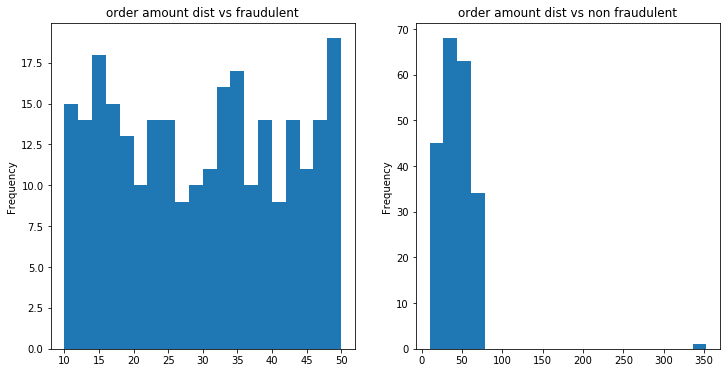

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))

#  fraudulent vs non-fraudulent dist

orders_df.loc[orders_df['fraudulent'] == False,'orderAmount'].plot(kind='hist',bins=20, ax = ax1,title='order amount dist vs fraudulent');
orders_df.loc[orders_df['fraudulent'] == True,'orderAmount'].plot(kind='hist',bins=20, ax = ax2,title='order amount dist vs non fraudulent');


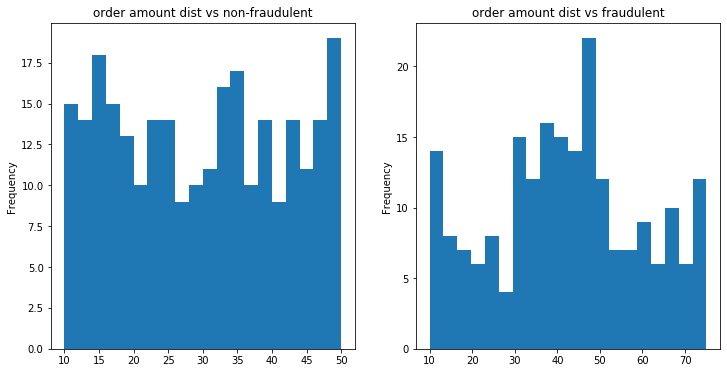

In [15]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6))

#  fraudulent vs non-fraudulent dist

orders_df.loc[orders_df['fraudulent'] == False,'orderAmount'].plot(kind='hist',bins=20, ax = ax1,title='order amount dist vs non-fraudulent');

# removeing the 350 order amount data point to compare distribution
orders_df.loc[((orders_df['fraudulent'] == True ) & (orders_df['orderAmount'] < 100)),'orderAmount'].plot(kind='hist',bins=20, ax = ax2,title='order amount dist vs fraudulent');


In [16]:

# order amount vs fraud
# max min amount in both instances (fraud,non fraud)

orderMoun_fraud = pd.DataFrame({'max amount':orders_df.groupby(['fraudulent'])['orderAmount'].max(),
                                'min amount':orders_df.groupby(['fraudulent'])['orderAmount'].min()})

orderMoun_fraud

,max amount,min amount
fraudulent,,
False,50,10
True,353,10


In [17]:
orders_df['orderState'].value_counts()

fulfilled    400
failed        50
pending       28
Name: orderState, dtype: int64

In [18]:
# orderState vs fraudulent or non

orders_df.groupby(['orderState','fraudulent'])['id'].count().unstack()

fraudulent,False,True
orderState,,
failed,27,23
fulfilled,223,177
pending,17,11


In [19]:

# percentage of fraud shared in between paymentmethodtype
print('percentage of fraud shared in between paymentmethodtype')
paym_df.groupby(['paymentMethodType','fraudulent'])['id'].count().unstack()/len(paym_df) *100


percentage of fraud shared in between paymentmethodtype


fraudulent,False,True
paymentMethodType,,
apple pay,3.508772,7.017544
bitcoin,2.923977,5.263158
card,33.333333,37.426901
paypal,6.140351,4.385965


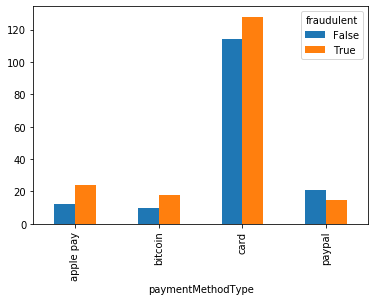

In [20]:
# bar chart for viz paymentmethodtype 
paym_df.groupby(['paymentMethodType','fraudulent'])['id'].count().unstack().plot(kind='bar');

In [21]:

# percentage of fraud and non fraud transactions shared betwwn payment method issuer

paym_df.groupby(['paymentMethodIssuer','fraudulent'])['id'].count().unstack()/len(paym_df)*100

fraudulent,False,True
paymentMethodIssuer,,
,NaN,0.584795
B,NaN,2.046784
Bastion Banks,3.508772,4.970760
Bulwark Trust Corp.,4.093567,4.385965
Citizens First Banks,4.093567,4.093567
Fountain Financial Inc.,4.093567,6.140351
Grand Credit Corporation,4.970760,2.923977
Her Majesty Trust,7.017544,5.555556
His Majesty Bank Corp.,4.678363,4.970760


In [22]:

paym_df.groupby(['paymentMethodIssuer','fraudulent'])['id'].count().unstack()

fraudulent,False,True
paymentMethodIssuer,,
,NaN,2.0
B,NaN,7.0
Bastion Banks,12.0,17.0
Bulwark Trust Corp.,14.0,15.0
Citizens First Banks,14.0,14.0
Fountain Financial Inc.,14.0,21.0
Grand Credit Corporation,17.0,10.0
Her Majesty Trust,24.0,19.0
His Majesty Bank Corp.,16.0,17.0


* fraudulent transactions occured when some uncommon name or unidentified paymentMethodIssuer is used.

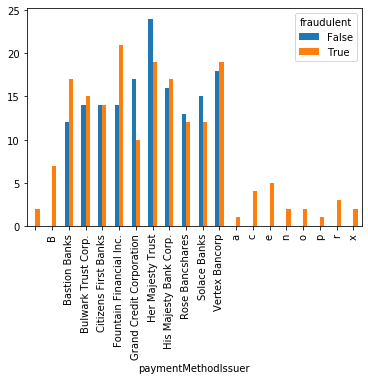

In [23]:
paym_df.groupby(['paymentMethodIssuer','fraudulent'])['id'].count().unstack().plot(kind='bar')

In [24]:
paym_df['paymentMethodProvider'].value_counts()

JCB 16 digit                   65
VISA 16 digit                  57
Voyager                        36
Diners Club / Carte Blanche    34
Maestro                        32
VISA 13 digit                  32
Discover                       25
American Express               22
JCB 15 digit                   20
Mastercard                     19
Name: paymentMethodProvider, dtype: int64

In [25]:
paym_df.groupby(['paymentMethodProvider','fraudulent'])['id'].count().unstack()

fraudulent,False,True
paymentMethodProvider,,
American Express,10,12
Diners Club / Carte Blanche,15,19
Discover,15,10
JCB 15 digit,11,9
JCB 16 digit,25,40
Maestro,20,12
Mastercard,8,11
VISA 13 digit,13,19
VISA 16 digit,26,31


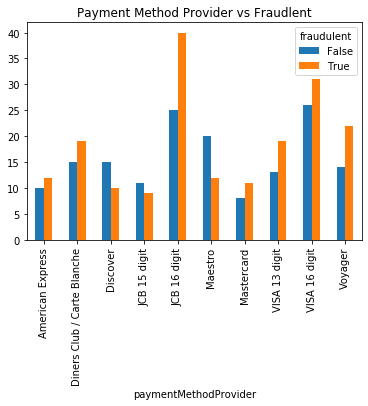

In [26]:
#plt.figure(figsize = (12,6));
paym_df.groupby(['paymentMethodProvider','fraudulent'])['id'].count().unstack().plot(kind='bar',
                                                                                     title='Payment Method Provider vs Fraudlent'
                                                                                     );


* JCB 16 digit is not secure, more fraud transactions occured using JCB 16 digit  Paymentmethod provider.

## feature selection.

In [0]:

# mergin data frames


In [0]:
# merging orders and transanctions using order Id
# df2 merging with paym_df on paymentMethodId 

In [28]:
orders_df.shape,trans_df.shape,paym_df.shape,customer_df.shape

((478, 6), (623, 7), (342, 7), (168, 8))

In [0]:
df = pd.merge(orders_df,trans_df,how='inner',on='orderId')

In [30]:
df.shape

(623, 12)

In [31]:
df.isnull().sum()

id_x                    0
orderId                 0
orderAmount             0
orderState              0
orderShippingAddress    0
fraudulent_x            0
id_y                    0
transactionId           0
paymentMethodId         0
transactionAmount       0
transactionFailed       0
fraudulent_y            0
dtype: int64

In [0]:
df.drop(['id_x','orderId','orderShippingAddress','fraudulent_x','id_y','transactionId','transactionAmount'],axis=1,inplace=True)

In [0]:
df2 = pd.merge(df,paym_df,how='inner',on='paymentMethodId')

In [34]:
paym_df['paymentMethodId'].nunique()

342

In [0]:
df2.drop(['paymentMethodId','fraudulent_y'],axis=1,inplace=True)

In [0]:
df3 = pd.merge(df2,customer_df,how='inner',on='id')

In [0]:
df3.drop(['id','customerEmail','customerPhone','customerDevice','customerIPAddress','customerBillingAddress','fraudulent_y'],axis=1,inplace=True)

In [38]:
df3.shape

(623, 9)

In [39]:
df3.isnull().sum()

orderAmount                         0
orderState                          0
transactionFailed                   0
paymentMethodRegistrationFailure    0
paymentMethodType                   0
paymentMethodProvider               0
paymentMethodIssuer                 0
fraudulent_x                        0
customerDeviceType                  0
dtype: int64

In [0]:
columns = df3.columns

In [0]:
# lable encoding

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,LabelBinarizer

In [0]:

df3 = df3.apply(LabelEncoder().fit_transform)

In [43]:
df3.head()

,orderAmount,orderState,transactionFailed,paymentMethodRegistrationFailure,paymentMethodType,paymentMethodProvider,paymentMethodIssuer,fraudulent_x,customerDeviceType
0,8,2,0,1,2,4,3,0,1
1,16,1,0,1,2,4,3,0,1
2,35,1,0,0,1,0,1,1,1
3,13,1,0,0,1,0,1,1,1
4,33,1,1,1,1,8,9,1,1


In [44]:
pd.DataFrame({'unique_val':df3.nunique() })

,unique_val
orderAmount,67
orderState,3
transactionFailed,2
paymentMethodRegistrationFailure,2
paymentMethodType,4
paymentMethodProvider,10
paymentMethodIssuer,19
fraudulent_x,2
customerDeviceType,2


In [0]:
y = df3['fraudulent_x']

In [0]:
df3.drop('fraudulent_x',axis=1,inplace=True)

In [47]:
# One hot encoding features
ohe = OneHotEncoder()

spars_df = ohe.fit_transform(df3.drop('orderAmount',axis=1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [0]:
df_all = pd.DataFrame(data=spars_df,columns=ohe.get_feature_names(df3.drop('orderAmount',axis=1).columns))

In [49]:
ohe.get_feature_names(df3.drop('orderAmount',axis=1).columns)

array(['orderState_0.0', 'orderState_1.0', 'orderState_2.0',
       'transactionFailed_0.0', 'transactionFailed_1.0',
       'paymentMethodRegistrationFailure_0.0',
       'paymentMethodRegistrationFailure_1.0', 'paymentMethodType_0.0',
       'paymentMethodType_1.0', 'paymentMethodType_2.0',
       'paymentMethodType_3.0', 'paymentMethodProvider_0.0',
       'paymentMethodProvider_1.0', 'paymentMethodProvider_2.0',
       'paymentMethodProvider_3.0', 'paymentMethodProvider_4.0',
       'paymentMethodProvider_5.0', 'paymentMethodProvider_6.0',
       'paymentMethodProvider_7.0', 'paymentMethodProvider_8.0',
       'paymentMethodProvider_9.0', 'paymentMethodIssuer_0.0',
       'paymentMethodIssuer_1.0', 'paymentMethodIssuer_2.0',
       'paymentMethodIssuer_3.0', 'paymentMethodIssuer_4.0',
       'paymentMethodIssuer_5.0', 'paymentMethodIssuer_6.0',
       'paymentMethodIssuer_7.0', 'paymentMethodIssuer_8.0',
       'paymentMethodIssuer_9.0', 'paymentMethodIssuer_10.0',
       'paymentM

In [50]:
df_all.corr()

,orderState_0.0,orderState_1.0,orderState_2.0,transactionFailed_0.0,transactionFailed_1.0,paymentMethodRegistrationFailure_0.0,paymentMethodRegistrationFailure_1.0,paymentMethodType_0.0,paymentMethodType_1.0,paymentMethodType_2.0,paymentMethodType_3.0,paymentMethodProvider_0.0,paymentMethodProvider_1.0,paymentMethodProvider_2.0,paymentMethodProvider_3.0,paymentMethodProvider_4.0,paymentMethodProvider_5.0,paymentMethodProvider_6.0,paymentMethodProvider_7.0,paymentMethodProvider_8.0,paymentMethodProvider_9.0,paymentMethodIssuer_0.0,paymentMethodIssuer_1.0,paymentMethodIssuer_2.0,paymentMethodIssuer_3.0,paymentMethodIssuer_4.0,paymentMethodIssuer_5.0,paymentMethodIssuer_6.0,paymentMethodIssuer_7.0,paymentMethodIssuer_8.0,paymentMethodIssuer_9.0,paymentMethodIssuer_10.0,paymentMethodIssuer_11.0,paymentMethodIssuer_12.0,paymentMethodIssuer_13.0,paymentMethodIssuer_14.0,paymentMethodIssuer_15.0,paymentMethodIssuer_16.0,paymentMethodIssuer_17.0,paymentMethodIssuer_18.0,customerDeviceType_0.0,customerDeviceType_1.0
orderState_0.0,1.000000,-0.736562,-0.092462,0.035855,-0.035855,0.020348,-0.020348,-0.018889,0.025142,-0.005534,0.002916,0.029809,-0.015852,-0.046080,-0.052455,0.041678,-0.033548,-0.005691,-0.089142,0.122278,-0.003019,-0.042840,0.002470,-0.017570,0.045755,0.034876,0.026989,0.005637,-0.062228,0.000613,-0.003136,-0.006548,-0.026963,0.014756,-0.035755,-0.013449,-0.019035,-0.013449,0.075952,-0.026963,-0.021508,0.021508
orderState_1.0,-0.736562,1.000000,-0.605369,0.030170,-0.030170,-0.026227,0.026227,0.006572,0.017278,0.002706,-0.028025,-0.020900,-0.073797,0.000716,0.011980,-0.007967,0.025098,0.028842,0.087315,-0.076762,0.049786,0.058162,0.043375,-0.041668,-0.038309,0.004400,-0.008307,0.004639,-0.039486,0.001936,0.052208,-0.002538,0.036606,-0.032211,0.048543,0.018259,0.025843,-0.088052,-0.042248,0.036606,0.027142,-0.027142
orderState_2.0,-0.092462,-0.605369,1.000000,-0.086609,0.086609,0.014665,-0.014665,0.012552,-0.055023,0.002529,0.037825,-0.004312,0.127294,0.053172,0.044092,-0.037317,0.002532,-0.035763,-0.023638,-0.030891,-0.069740,-0.035209,-0.066762,0.082017,0.002552,-0.047519,-0.019531,-0.013463,0.131359,-0.003572,-0.073167,0.011441,-0.022160,0.030054,-0.029386,-0.011053,-0.015644,0.145451,-0.027184,-0.022160,-0.014647,0.014647
transactionFailed_0.0,0.035855,0.030170,-0.086609,1.000000,-1.000000,-0.001202,0.001202,0.002868,0.022928,-0.041453,0.039929,0.001884,-0.066714,-0.086704,-0.054004,0.072187,0.006993,0.026695,-0.066714,0.079019,0.029810,0.020049,-0.066714,-0.038168,0.048847,0.075765,0.048847,-0.072892,-0.088407,-0.001110,0.044581,0.011862,0.048847,-0.003856,0.064775,0.024364,0.034484,0.024364,-0.014148,0.003562,0.024270,-0.024270
transactionFailed_1.0,-0.035855,-0.030170,0.086609,-1.000000,1.000000,0.001202,-0.001202,-0.002868,-0.022928,0.041453,-0.039929,-0.001884,0.066714,0.086704,0.054004,-0.072187,-0.006993,-0.026695,0.066714,-0.079019,-0.029810,-0.020049,0.066714,0.038168,-0.048847,-0.075765,-0.048847,0.072892,0.088407,0.001110,-0.044581,-0.011862,-0.048847,0.003856,-0.064775,-0.024364,-0.034484,-0.024364,0.014148,-0.003562,-0.024270,0.024270
paymentMethodRegistrationFailure_0.0,0.020348,-0.026227,0.014665,-0.001202,0.001202,1.000000,-1.000000,0.060838,-0.230356,0.056837,0.076876,-0.056435,-0.054999,-0.049853,0.108630,0.042789,-0.013890,0.090592,-0.234736,0.034660,0.128264,0.049725,0.043039,0.061060,0.054208,-0.243057,0.104413,0.134015,-0.006906,-0.149735,-0.088150,0.020348,0.031296,0.041502,-0.048587,0.015610,0.022094,0.015610,0.038392,0.031296,-0.020961,0.020961
paymentMethodRegistrationFailure_1.0,-0.020348,0.026227,-0.014665,0.001202,-0.001202,-1.000000,1.000000,-0.060838,0.230356,-0.056837,-0.076876,0.056435,0.054999,0.049853,-0.108630,-0.042789,0.013890,-0.090592,0.234736,-0.034660,-0.128264,-0.049725,-0.043039,-0.061060,-0.054208,0.243057,-0.104413,-0.134015,0.006906,0.149735,0.088150,-0.020348,-0.031296,-0.041502,0.048587,-0.015610,-0.022094,-0.015610,-0.038392,-0.031296,0.020961,-0.020961
paymentMethodTyp

In [51]:
y.shape,df_all.shape

((623,), (623, 42))

In [0]:
df_all['fraudulent'] = y

In [53]:
# corr from 'fraudulent'
df_all.corr()['fraudulent'].sort_values(ascending=False)

fraudulent                              1.000000
paymentMethodIssuer_0.0                 0.152421
paymentMethodIssuer_12.0                0.127213
paymentMethodIssuer_13.0                0.127213
paymentMethodIssuer_17.0                0.117681
paymentMethodProvider_7.0               0.101820
paymentMethodIssuer_18.0                0.095931
paymentMethodIssuer_11.0                0.095931
paymentMethodIssuer_2.0                 0.085314
paymentMethodProvider_9.0               0.075001
paymentMethodIssuer_3.0                 0.072536
transactionFailed_0.0                   0.068354
paymentMethodIssuer_15.0                0.067724
paymentMethodType_1.0                   0.056934
paymentMethodProvider_8.0               0.048750
paymentMethodIssuer_14.0                0.047850
paymentMethodIssuer_16.0                0.047850
orderState_1.0                          0.044432
paymentMethodType_2.0                   0.041789
paymentMethodIssuer_8.0                 0.040771
paymentMethodRegistr

In [0]:
# corr matrix
corr = df_all.corr()

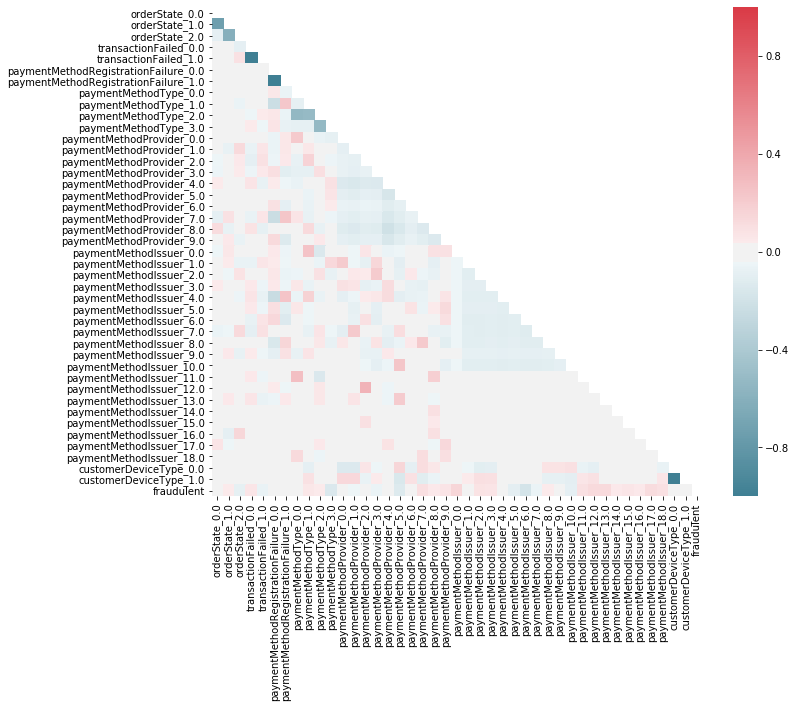

In [55]:
# correlation heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap)

In [0]:
# spliting train and validation 
X_train, X_val, y_train, y_val = train_test_split(df_all.drop('fraudulent',axis=1), df_all['fraudulent'], test_size=0.20, random_state=42)

In [0]:
# intializing model
xgbcls = xgb.XGBClassifier(max_depth=10,eta=0.1,subsample=0.7,n_estimators=150)

In [58]:
# training with all data
xgbcls.fit(df_all.drop('fraudulent',axis=1),df_all['fraudulent'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

In [0]:
# prediction for complete dataset
y_pred = xgbcls.predict_proba(df_all.drop('fraudulent',axis=1))[:,1]

In [0]:
# roc_auc curve
fpr, tpr, _ = roc_curve(df_all['fraudulent'], y_pred)
roc_auc = auc(fpr, tpr)

In [64]:
# accuracy
roc_auc

0.9830271523037997

In [68]:
roc_auc_score(df_all['fraudulent'],y_pred)

0.9830271523037997

In [0]:
# feature importance 

features_imp = pd.DataFrame({'feature':df_all.drop('fraudulent',axis=1).columns,'importance':xgbcls.feature_importances_})


In [67]:

# top 10 features
features_imp.sort_values(by='importance',ascending=False)[:10]

,feature,importance
21,paymentMethodIssuer_0.0,0.069703
34,paymentMethodIssuer_13.0,0.069572
33,paymentMethodIssuer_12.0,0.060709
38,paymentMethodIssuer_17.0,0.055497
10,paymentMethodType_3.0,0.041190
27,paymentMethodIssuer_6.0,0.040836
2,orderState_2.0,0.034662
14,paymentMethodProvider_3.0,0.033019
31,paymentMethodIssuer_10.0,0.029425
23,paymentMethodIssuer_2.0,0.028759
